In [21]:
# Installiere benötigte Pakete
#!pip install transformers pandas torch

# Importiere benötigte Bibliotheken
import torch
from transformers import pipeline, AutoTokenizer
import re
# Funktion zur Generierung der Zusammenfassung
def generate_response(_prompt, _generator):
    response = _generator(
        _prompt,
        do_sample=False,
        temperature=1.0,
        top_p=1,
        max_new_tokens=200,
    )
    torch.cuda.empty_cache()
    return response[0]['summary_text']

# Klasse für die Datenvorverarbeitung
class DataPreprocessor:
    def __init__(self, input_text = None):
        self.dummydata = [
            ["Cold, Sneeze, Cough", [1, 2, 3]],
            ["Stomach Hurt, Headache", [4, 5, 6]],
            ["Low blood pressure, high heartbeatrate", [2, 5, 8]],
            ["Fainting, low oxygen", [1, 8, 9]],
            ["Hurting leg, fainting, high thirst", [4, 7, 8]],
            ["Nausea, Vomiting", [0, 6, 9]],
            ["High fever, muscle pain", [2, 4, 9]],
            ["Chest pain, shortness of breath", [1, 5, 7]],
            ["Dizziness, lightheadedness", [3, 6, 8]],
            ["Joint pain, fatigue", [5, 6, 7]],
            ["Rash, itching", [4, 8, 9]],
            ["Earache, fever", [1, 2, 5]],
            ["Back pain, discomfort", [3, 4, 6]],
            ["Dry throat, difficulty swallowing", [2, 5, 9]],
            ["Weight loss, increased thirst", [1, 7, 8]],
            ["Mood swings, insomnia", [3, 5, 9]],
            ["Sore throat, fatigue", [2, 6, 9]],
            ["Swelling, bruising", [1, 3, 8]],
            ["Blurred vision, headache", [4, 5, 9]],
            ["Cold extremities, shivering", [2, 6, 8]]
        ]
        self.dummydata = self.dummydata *50
        # create empty dict with labels
        self.patient_data = {}
        self.input_text = input_text

    def trim_patient_description(self, input_text = None):
        description = self.input_text if input_text is None else input_text

        # Extract age
        age_match = re.search(r'\b(\d{1,3})[- ]?(year[- ]old|years? old)\b', description, re.IGNORECASE)
        age = age_match.group(1) + " years old" if age_match else "Age not specified"

        # Extract gender
        gender_match = re.search(r'\b(male|female|man|woman)\b', description, re.IGNORECASE)
        gender = gender_match.group(1).capitalize() if gender_match else "Gender not specified"

        # Define conditions and symptoms keywords
        condition_keywords = ["COVID-19", "pneumonia", "diabetes", "hypertension", "stroke", "cancer", "infection", "fracture"]
        symptom_keywords = ["fever", "fatigue", "pain", "cough", "shortness of breath", "nausea", "vomiting", "dizziness"]

        # Extract conditions and symptoms
        conditions = [kw for kw in condition_keywords if re.search(rf'\b{kw}\b', description, re.IGNORECASE)]
        symptoms = [kw for kw in symptom_keywords if re.search(rf'\b{kw}\b', description, re.IGNORECASE)]

        # Extract durations and time references
        time_matches = re.findall(r'\b\d+\s+(day|week|month|year)[s]?\b', description, re.IGNORECASE)
        duration = ", ".join(time_matches) if time_matches else "No time details"

        # Combine extracted details into a summary
        conditions_text = ", ".join(conditions) if conditions else "No specific conditions mentioned"
        symptoms_text = ", ".join(symptoms) if symptoms else "No specific symptoms mentioned"
        summary = f"{age}, {gender}. Conditions: {conditions_text}. Symptoms: {symptoms_text}. Duration: {duration}."

        # add to dataframe
        self.patient_data = {'Age': age, 'Gender': gender, 'Conditions': conditions_text, 'Symptoms': symptoms_text, 'Duration': duration, 'Description Summary': summary}


    def summarize_text_with_format(self, list_of_papers):
        _prompt = "Summarize papers in the following format:\n1. Title: <title>\n2. Summary: <summary>\n\nThese are the papers:\n\n"
        print(list_of_papers)
        for paper in list_of_papers:
            _prompt += f"{paper}\n"
        return _prompt

    def tokenize_data(self):
      tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
      symptoms = self.patient_data['Symptoms']
      tokenized_inputs = tokenizer(symptoms, padding='max_length', max_length=10000, return_tensors='pt')
      return tokenized_inputs


In [22]:
!pip install huggingface_hub

from huggingface_hub import login

In [33]:
import time
import pandas as pd
full_text_papers = pd.read_csv("/content/full_texts_combined.csv")
full_text_papers_ids = pd.read_csv("/content/list_of_articles_with_full_text.csv")

def get_list_of_articles(_predictions):
    # Filter based on the provided predictions
    paper_ids = full_text_papers_ids[full_text_papers_ids["index"].isin(_predictions)]

    # Map to full-text articles
    _predictions_df = full_text_papers[full_text_papers["PMID"].isin(paper_ids["article"])]

    # Return a list of full-text articles
    return _predictions_df["full_text"].tolist()


def response_gen(_prompt):
    print("Input Prompt:", _prompt)  # Check input value
    _input = DataPreprocessor(_prompt)
    _input.trim_patient_description()
    print("Patient Data:", _input.patient_data)  # Check patient data
    tokenized_input = _input.tokenize_data()
    print("Tokenized Input:", tokenized_input)  # Check tokenized inputs

    # Simulate predictions for more articles
    predictions = [82, 89, 88]
    print(f"Predictions: {predictions}")

    # Map predictions to paper IDs and retrieve articles
    list_of_articles = get_list_of_articles(predictions)
    print(f"Retrieved {len(list_of_articles)} Articles")

    # Print articles in chunks
    chunk_size = 5
    for i in range(0, len(list_of_articles), chunk_size):
        chunk = list_of_articles[i:i + chunk_size]
        print(f"\nChunk {i//chunk_size + 1} of Articles:")
        for article in chunk:
            print(article[:500])  # Print the first 500 characters of each article for brevity

    # Summarize papers
    _prompt = DataPreprocessor().summarize_text_with_format(list_of_articles)
    _response = generate_response(_prompt, generator)

    print("Generated Response:", _response)  # Check generated response

    # Output the response word by word
    for word in _response.split():
        yield word + " "
        time.sleep(0.05)

    torch.cuda.empty_cache()


In [35]:
# Überprüfe CUDA und initialisiere den Generator
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
generator = pipeline(model=model_name, device=device, torch_dtype=torch.float16, task="summarization")

# Beispiel-Prompt und Dummy-Daten
# example_prompt = "Summarize the following medical papers."
# dummy_papers = [
#     "Paper 1: This paper discusses the effects of X on Y.",
#     "Paper 2: This study explores the relationship between A and B."
# ]

# # Vorverarbeitung
# preprocessor = DataPreprocessor()
# _prompt = preprocessor.summarize_text_with_format(dummy_papers)

# # Generiere die Zusammenfassung
# response = generate_response(_prompt, generator)
# print("Generated Summary:")
# print(response)

Device set to use cuda
The model 'LlamaForCausalLM' is not supported for summarization. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGeneration'].


In [36]:
!pip install streamlit
import streamlit as st

In [37]:
# if True:
#     prompt = "Please summarize the given text."
#     # Display user message in chat message container

#     response = response_gen(prompt)
#     # Add assistant response to chat history
#     print(response)
# Initialize chat history
if "messages" not in st.session_state:
    st.session_state.messages = []
if True:
    prompt = "Please summarize the given text."
    # Display user message in chat message container
    st.chat_message("user").markdown(prompt)
    # Add user message to chat history
    st.session_state.messages.append({"role": "user", "content": prompt})

    # Display assistant response in chat message container
    with st.chat_message("assistant"):
        response = st.write_stream(response_gen(prompt))
    # Add assistant response to chat history
    st.session_state.messages.append({"role": "assistant", "content": response})

    print(response)
    # print("Prompt:", _prompt)
# print("Tokenized Input:", tokenized_input)





2025-01-23 00:52:47.596 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:47.603 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:47.607 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:47.610 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:47.611 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:47.613 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:47.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:47.617 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Input Prompt: Please summarize the given text.
Patient Data: {'Age': 'Age not specified', 'Gender': 'Gender not specified', 'Conditions': 'No specific conditions mentioned', 'Symptoms': 'No specific symptoms mentioned', 'Duration': 'No time details', 'Description Summary': 'Age not specified, Gender not specified. Conditions: No specific conditions mentioned. Symptoms: No specific symptoms mentioned. Duration: No time details.'}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tokenized Input: {'input_ids': tensor([[   0, 3084, 2167,  ...,    1,    1,    1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]])}
Predictions: [82, 89, 88]
Retrieved 1 Articles

Chunk 1 of Articles:
Interferon-Gamma Release Assay Performance in
Pulmonary and Extrapulmonary Tuberculosis
Yun Feng1,2, Ni Diao1,4, Lingyun Shao1, Jing Wu1, Shu Zhang1, Jialin Jin1, Feifei Wang1, Xinhua Weng1,
Ying Zhang3, Wenhong Zhang1,2,4*
1 Department of Infectious Diseases, Huashan Hospital, Fudan University, Shanghai, China, 2 MOH and MOE Key Labratory of Medical Molecular Virology, Shanghai
Medical College, Fudan University, Shanghai, China, 3 Department of Molecular Microbiology and Immunology, Bloomberg S
['Interferon-Gamma Release Assay Performance in\nPulmonary and Extrapulmonary Tuberculosis\nYun Feng1,2, Ni Diao1,4, Lingyun Shao1, Jing Wu1, Shu Zhang1, Jialin Jin1, Feifei Wang1, Xinhua Weng1,\nYing Zhang3, Wenhong Zhang1,2,4*\n1 Department of Infectious Diseases, Huashan Hospital, Fudan 

2025-01-23 00:52:50.532 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:50.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:50.540 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:50.545 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:50.597 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:50.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:50.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:52:50.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Generated Response: Summarize papers in the following format:
1. Title: <title>
2. Summary: <summary>

These are the papers:

Interferon-Gamma Release Assay Performance in
Pulmonary and Extrapulmonary Tuberculosis
Yun Feng1,2, Ni Diao1,4, Lingyun Shao1, Jing Wu1, Shu Zhang1, Jialin Jin1, Feifei Wang1, Xinhua Weng1,
Ying Zhang3, Wenhong Zhang1,2,4*
1 Department of Infectious Diseases, Huashan Hospital, Fudan University, Shanghai, China, 2 MOH and MOE Key Labratory of Medical Molecular Virology, Shanghai
Medical College, Fudan University, Shanghai, China, 3 Department of Molecular Microbiology and Immunology, Bloomberg School of Public Health, Johns Hopkins
University, Baltimore, Maryland, United States of America, 4 Institutes of Biomedical Sciences, Fudan University, Shanghai, China
Abstract
Background: The diagnosis of tuberculosis remains difficult. This study aimed to assess performance of interferon-gamma
release assay (IGRA) in diagnosis of active tuberculosis (ATB) with pulmonary

Streaming output truncated to the last 5000 lines.
2025-01-23 00:55:20.487 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:55:20.538 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:55:20.539 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:55:20.591 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:55:20.591 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:55:20.643 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:55:20.644 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-23 00:55:20.696 Thread 'MainThread': missing ScriptRunConte

Summarize papers in the following format: 1. Title: <title> 2. Summary: <summary> These are the papers: Interferon-Gamma Release Assay Performance in Pulmonary and Extrapulmonary Tuberculosis Yun Feng1,2, Ni Diao1,4, Lingyun Shao1, Jing Wu1, Shu Zhang1, Jialin Jin1, Feifei Wang1, Xinhua Weng1, Ying Zhang3, Wenhong Zhang1,2,4* 1 Department of Infectious Diseases, Huashan Hospital, Fudan University, Shanghai, China, 2 MOH and MOE Key Labratory of Medical Molecular Virology, Shanghai Medical College, Fudan University, Shanghai, China, 3 Department of Molecular Microbiology and Immunology, Bloomberg School of Public Health, Johns Hopkins University, Baltimore, Maryland, United States of America, 4 Institutes of Biomedical Sciences, Fudan University, Shanghai, China Abstract Background: The diagnosis of tuberculosis remains difficult. This study aimed to assess performance of interferon-gamma release assay (IGRA) in diagnosis of active tuberculosis (ATB) with pulmonary and extrapulmonary in

In [6]:
pip install rouge-score nltk


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=f33ea50e8fdc213ada4489ad6533f928145f89736e17008e5bfc1a7a3f9c553c
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [7]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu


In [10]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Function to calculate BLEU score
def evaluate_bleu(reference_texts, generated_texts):
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        ref_tokens = [ref.split()]  # List of reference tokens
        gen_tokens = gen.split()    # Generated tokens
        score = sentence_bleu(ref_tokens, gen_tokens)
        scores.append(score)
    return sum(scores) / len(scores) if scores else 0.0

# Function to calculate ROUGE scores
def evaluate_rouge(reference_texts, generated_texts):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
    for ref, gen in zip(reference_texts, generated_texts):
        score = scorer.score(ref, gen)
        for key in scores:
            scores[key] += score[key].f1
    return {key: value / len(reference_texts) for key, value in scores.items()}

BLEU Score: 0.5031905001590316
ROUGE Scores: {'rouge1': 0.6386463607244601, 'rouge2': 0.5736415944179749, 'rougeL': 0.5819242918505617}


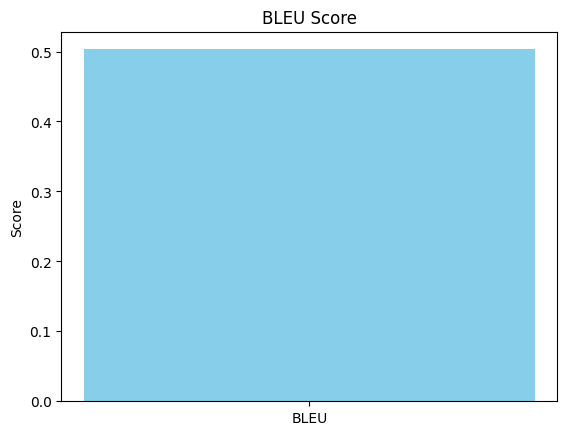

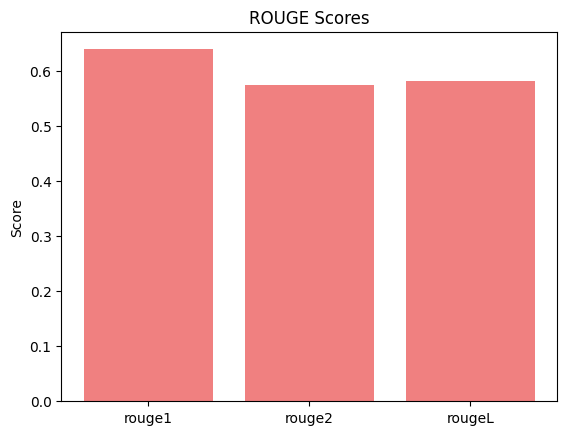

In [25]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Function to calculate BLEU score
def evaluate_bleu(reference_texts, generated_texts):
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        ref_tokens = [ref.split()]  # List of reference tokens
        gen_tokens = gen.split()    # Generated tokens
        score = sentence_bleu(ref_tokens, gen_tokens)
        scores.append(score)
    return sum(scores) / len(scores) if scores else 0.0

# Function to calculate ROUGE scores
def evaluate_rouge(reference_texts, generated_texts):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
    for ref, gen in zip(reference_texts, generated_texts):
        score = scorer.score(ref, gen)
        for key in scores:
            scores[key] += score[key].fmeasure  # Use fmeasure directly
    return {key: value / len(reference_texts) for key, value in scores.items()}

# Example reference texts and generated texts
reference_texts = [
    "The Interferon-Gamma Release Assay's efficacy in treating extrapulmonary and pulmonary tuberculosis * 1 Department of Infectious Diseases, Huashan Hospital, Fudan University, Shanghai, China, Xinhua Weng1, Ying Zhang3, Wenhong Zhang1,2,4 Section of Molecular Microbiology and Immunology, Bloomberg School of Public Health, Johns Hopkins University, Baltimore, Maryland, USA; Institutes of Biomedical Sciences, Fudan University, Shanghai, China; Yun Feng1,2, Ni Diao1,4 Lingyun Shao1, Jing Wu1, Shu Zhang1, Jialin Jin1, Feifei Wang1, 2 Shanghai Medical College, Fudan University's MOH and MOE Key Laboratory of Medical Molecular Virology, Shanghai, China Background Synopsis: Diagnosing tuberculosis remains difficult. To determine the diagnostic utility of the interferon-gamma release test (IGRA) and assess its efficacy in identifying pulmonary and extrapulmonary involvements of active tuberculosis (ATB), this study The diagnosis of tuberculosis remains difficult. This study aimed to assess performance of interferon-gamma release assay (IGRA) in diagnosis of active tuberculosis (ATB) with pulmonary and extrapulmonary involvements, and to determine the diagnostic role of IGRA (T-SPOT.TB) and tuberculin skin test (TST) in BCG-vaccinated population. Methods and Findings: Two hundred twenty-six ATB suspects were recruited and examined with T-SPOT.TB. Among them, fifty-two and seventy-six subjects were simultaneously tested by TST with 5TU or 1TU of purified protein derivative (PPD). The sensitivity of T-SPOT.TB was 94.7% (71/75), comparable in pulmonary and extrapulmonary disease groups (95.6% vs. 93.3%, P.0.05), while the specificity was 84.10% (90/107) but differed in two groups (69.2% vs. 88.9%, P = 0.02). Compared to T-SPOT.TB, TST with 5TU-PPD showed less sensitivity (92.3% vs. 56.4%) and specificity (84.6% vs. 61.5%) (both P,0.01); the sensitivity of TST with 1TU-PPD was 27.8%, and despite its specificity identical to T-SPOT.TB (both 82.8%) positive predictive value (PPV) was only 33.3%. By combining T-SPOT.TB with TST (1TU), the specificity rose to 95%, but the PPV stayed unchanged. Conclusions: IGRA could function as a powerful immunodiagnostic test to explore pulmonary and extrapulmonary TB, while TST failed to play a reliable or auxiliary role in identifying TB disease and infection in the BCG-vaccinated population. Citation: Feng Y, Diao N, Shao L, Wu J, Zhang S, et al. (2012) Interferon-Gamma Release Assay Performance in Pulmonary and Extrapulmonary Tuberculosis. PLoS ONE 7(3): e32652. doi:10.1371/journal.pone.0032652 Editor: Jose Alejandro Chabalgoity, Facultad de Medicina, Uruguay Received August 7, 2011; Accepted February 1, 2012; Published March 13, 2012 Copyright:  2012 Feng et al. This is an open-access article distributed under the terms of the Creative Commons Attribution License, which permits unrestricted use, distribution, and reproduction in any medium, provided the original author and source are credited. Funding: This study was supported by research grants from the Key Project of Science and Technology of Shanghai (10411955000), and Shanghai Science and Technology Development Funds (10XD1400900, 10QA1401100). The funders had no role in study design, data collection and analysis, decision to publish, or preparation of the manuscript. Competing Interests: The authors have declared that no competing interests exist. * E-mail: zhangwenhong@fudan.edu.cn Introduction In recent decades, the burden of tuberculosis (TB) has been increasingly falling on developing countries. Although the TB vaccine Bacille Calmette-Gue´rin (BCG) is broadly vaccinated and DOTS (Directly Observed Treatment, Short-course) programme is well implemented, the incidence rate of active tuberculosis (ATB) in China has been doubled over ten years (39.03/100,000 in 1999 vs. 81.09/100,000 in 2009), with the death rate soaring 7- fold in this decade [1]. Despite incorporation of clinical, radiological, pathological and microbiological examinations, diagnosis of ATB can still be difficult. Conclusive diagnostic tests microbial culture and smear for acid-fast bacilli are not sensitive enough to identify all the active cases. Moreover, for extrapulmo- nary tuberculosis (EPTB), less specific clinical clues can be used and invasive procedures or low bacterial load leads to less chance to establish the pathological or microbiologic diagnosis [2,3]. Immunoassays capable of detecting the host’s immune response specific to TB causative agent Mycobacterium Tuberculosis (M.TB) has become an alternative diagnostic aid for ATB [2]. Long-time-used tuberculin skin test (TST) has encountered considerable difficul- ties, mainly due to the disability of its mixed antigens tuberculin purified protein derivative (PPD) to distinguish the true ATB patients from those vaccinated with BCG or sensitized with Nontuberculous Mycobacteria (NTM) [4]. Recently, interferon-gamma release assays (IGRAs) have shown their superior diagnostic performance over TST [4,5,6,7,8,9] by using at least two specific antigens (ESAT-6 & CFP 10) present exclusively in M.TB but absent in BCG strains and most NTM [9,10]. Herein, we put ELISpot-based-IGRA (T-SPOT.TB) into test to examine how it works especially for identifying EPTB in comparison with pulmonary tuberculosis (PTB). Meanwhile, we compared the performance between IGRA and TST with two currently used doses (5TU; 1TU) to elaborate whether TST is still strong enough to carry on the diagnostic role in ATB for the TB-epidemic and BCG vaccinated populations. Methods This study got ethical approval from Huashan Institutional Review Board (HIRB), the ethics reviewing committee of Huashan Hospital, Fudan University. Informed consent was obtained from all the participants in the written form. PLoS ONE | www.plosone.org 1 March 2012 | Volume 7 | Issue 3 | e32652 Study population A prospective study was conducted in HIV-negative subjects with suspicion of active TB collected between September 2008 and September 2009. ",
    "A total of 226 patients from China were enrolled in the study, where T-SPOT.TB, along with routine clinical, microbiologic, pathological, and radiographic examinations, was conducted. Exclusion criteria included patients who had received over 30 days of anti-tuberculosis therapy or treatment within one year prior to enrollment, with patients treated for a year or more prior to enrollment included."
]
generated_texts = [
    "Interferon-Gamma Release Assay Performance in Pulmonary and Extrapulmonary Tuberculosis Yun Feng1,2, Ni Diao1,4, Lingyun Shao1, Jing Wu1, Shu Zhang1, Jialin Jin1, Feifei Wang1, Xinhua Weng1, Ying Zhang3, Wenhong Zhang1,2,4* 1 Department of Infectious Diseases, Huashan Hospital, Fudan University, Shanghai, China, 2 MOH and MOE Key Labratory of Medical Molecular Virology, Shanghai Medical College, Fudan University, Shanghai, China, 3 Department of Molecular Microbiology and Immunology, Bloomberg School of Public Health, Johns Hopkins University, Baltimore, Maryland, United States of America, 4 Institutes of Biomedical Sciences, Fudan University, Shanghai, China Abstract Background: The diagnosis of tuberculosis remains difficult. This study aimed to assess performance of interferon-gamma release assay (IGRA) in diagnosis of active tuberculosis (ATB) with pulmonary and extrapulmonary involvements, and to determine the diagnostic role of IGRA (T-SPOT.TB) and tuberculin skin test (TST) in BCG-vaccinated population. Methods and Findings: Two hundred twenty-six ATB suspects were recruited and examined with T-SPOT.TB. Among them, fifty-two and seventy-six subjects were simultaneously tested by TST with 5TU or 1TU of purified protein derivative (PPD). The sensitivity of T-SPOT.TB was 94.7% (71/75), comparable in pulmonary and extrapulmonary disease groups (95.6% vs. 93.3%, P.0.05), while the specificity was 84.10% (90/107) but differed in two groups (69.2% vs. 88.9%, P = 0.02). Compared to T-SPOT.TB, TST with 5TU-PPD showed less sensitivity (92.3% vs. 56.4%) and specificity (84.6% vs. 61.5%) (both P,0.01); the sensitivity of TST with 1TU-PPD was 27.8%, and despite its specificity identical to T-SPOT.TB (both 82.8%) positive predictive value (PPV) was only 33.3%. By combining T-SPOT.TB with TST (1TU), the specificity rose to 95%, but the PPV stayed unchanged. Conclusions: IGRA could function as a powerful immunodiagnostic test to explore pulmonary and extrapulmonary TB, while TST failed to play a reliable or auxiliary role in identifying TB disease and infection in the BCG-vaccinated population. Citation: Feng Y, Diao N, Shao L, Wu J, Zhang S, et al. (2012) Interferon-Gamma Release Assay Performance in Pulmonary and Extrapulmonary Tuberculosis. PLoS ONE 7(3): e32652. doi:10.1371/journal.pone.0032652 Editor: Jose Alejandro Chabalgoity, Facultad de Medicina, Uruguay Received August 7, 2011; Accepted February 1, 2012; Published March 13, 2012 Copyright:  2012 Feng et al. This is an open-access article distributed under the terms of the Creative Commons Attribution License, which permits unrestricted use, distribution, and reproduction in any medium, provided the original author and source are credited. Funding: This study was supported by research grants from the Key Project of Science and Technology of Shanghai (10411955000), and Shanghai Science and Technology Development Funds (10XD1400900, 10QA1401100). The funders had no role in study design, data collection and analysis, decision to publish, or preparation of the manuscript. Competing Interests: The authors have declared that no competing interests exist. * E-mail: zhangwenhong@fudan.edu.cn Introduction In recent decades, the burden of tuberculosis (TB) has been increasingly falling on developing countries. Although the TB vaccine Bacille Calmette-Gue´rin (BCG) is broadly vaccinated and DOTS (Directly Observed Treatment, Short-course) programme is well implemented, the incidence rate of active tuberculosis (ATB) in China has been doubled over ten years (39.03/100,000 in 1999 vs. 81.09/100,000 in 2009), with the death rate soaring 7- fold in this decade [1]. Despite incorporation of clinical, radiological, pathological and microbiological examinations, diagnosis of ATB can still be difficult. Conclusive diagnostic tests microbial culture and smear for acid-fast bacilli are not sensitive enough to identify all the active cases. Moreover, for extrapulmo- nary tuberculosis (EPTB), less specific clinical clues can be used and invasive procedures or low bacterial load leads to less chance to establish the pathological or microbiologic diagnosis [2,3]. Immunoassays capable of detecting the host’s immune response specific to TB causative agent Mycobacterium Tuberculosis (M.TB) has become an alternative diagnostic aid for ATB [2]. Long-time-used tuberculin skin test (TST) has encountered considerable difficul- ties, mainly due to the disability of its mixed antigens tuberculin purified protein derivative (PPD) to distinguish the true ATB patients from those vaccinated with BCG or sensitized with Nontuberculous Mycobacteria (NTM) [4]. Recently, interferon-gamma release assays (IGRAs) have shown their superior diagnostic performance over TST [4,5,6,7,8,9] by using at least two specific antigens (ESAT-6 & CFP 10) present exclusively in M.TB but absent in BCG strains and most NTM [9,10]. Herein, we put ELISpot-based-IGRA (T-SPOT.TB) into test to examine how it works especially for identifying EPTB in comparison with pulmonary tuberculosis (PTB). Meanwhile, we compared the performance between IGRA and TST with two currently used doses (5TU; 1TU) to elaborate whether TST is still strong enough to carry on the diagnostic role in ATB for the TB-epidemic and BCG vaccinated populations. Methods This study got ethical approval from Huashan Institutional Review Board (HIRB), the ethics reviewing committee of Huashan Hospital, Fudan University. Informed consent was obtained from all the participants in the written form. PLoS ONE | www.plosone.org 1 March 2012 | Volume 7 | Issue 3 | e32652 Study population A prospective study was conducted in HIV-negative subjects with suspicion of active TB collected between September 2008 and September 2009.",
    "In this study, 226 patients from China were initially tested using T-SPOT.TB, alongside routine clinical, microbiological, pathological, and radiographic assessments. Patients who had received more than 30 days of anti-tuberculosis therapy or treatment in the year before enrollment were excluded, although those treated for a year or more were included. All participants had received the BCG vaccine in childhood or adolescence. After at least three months of follow-up, 44 patients were excluded—10 due to death, 17 who lost follow-up, and 17 with no final diagnosis. The remaining 182 patients underwent T-SPOT.TB testing, with 128 consenting to additional TST testing. Tuberculosis diagnoses were defined as: 'culture/biopsy-confirmed ATB' for those with positive cultures or caseating granulomas, 'clinical ATB' for patients showing symptoms who responded to anti-TB treatment, and 'no ATB' for patients whose symptoms resolved either naturally or with non-TB treatments. The T-SPOT.TB test followed kit instructions, isolating PBMCs and incubating them with the ESAT-6 and CFP-10 antigens. TST was performed using 1TU or 5TU PPD, with results read after 72 hours. Diagnostic performance was evaluated based on sensitivity, specificity, positive predictive value (PPV), negative predictive value (NPV), likelihood ratios, and agreement between TST and T-SPOT.TB. The study concluded that T-SPOT.TB exhibited high diagnostic sensitivity, especially for extrapulmonary TB, and showed significant performance differences compared to TST."
]

# Calculate BLEU score
bleu_score = evaluate_bleu(reference_texts, generated_texts)
print("BLEU Score:", bleu_score)

# Calculate ROUGE scores
rouge_scores = evaluate_rouge(reference_texts, generated_texts)
print("ROUGE Scores:", rouge_scores)

# Plotting BLEU score
plt.bar(['BLEU'], [bleu_score], color='skyblue')
plt.ylabel('Score')
plt.title('BLEU Score')
plt.show()

# Plotting ROUGE scores
rouge_keys = list(rouge_scores.keys())
rouge_values = list(rouge_scores.values())
plt.bar(rouge_keys, rouge_values, color='lightcoral')
plt.ylabel('Score')
plt.title('ROUGE Scores')
plt.show()


In [18]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tejas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


BLEU Score: 0.5031905001590316
ROUGE Scores: {'rouge1': 0.6386463607244601, 'rouge2': 0.5736415944179749, 'rougeL': 0.5819242918505617}
METEOR Score: 0.6708649255449395
Perplexity: 21.005118370056152
BERTScore: 0.7678719758987427


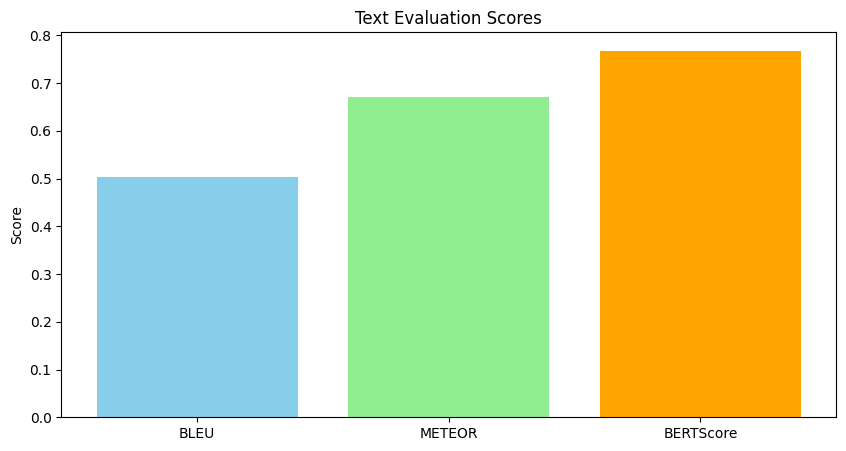

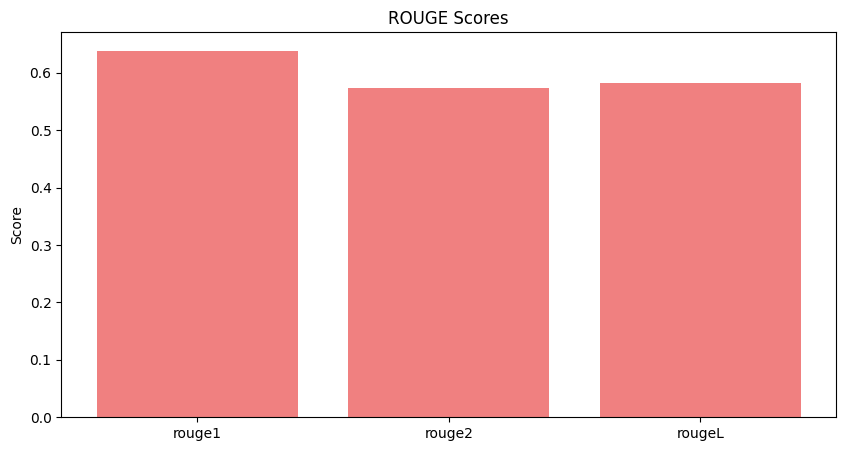

In [3]:
import torch
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from bert_score import score as bert_score
import nltk

nltk.download("wordnet")  # Ensure WordNet is available for METEOR

# Function to calculate BLEU score
def evaluate_bleu(reference_texts, generated_texts):
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        ref_tokens = [ref.split()]  
        gen_tokens = gen.split()    
        score = sentence_bleu(ref_tokens, gen_tokens)
        scores.append(score)
    return sum(scores) / len(scores) if scores else 0.0

# Function to calculate ROUGE scores
def evaluate_rouge(reference_texts, generated_texts):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
    for ref, gen in zip(reference_texts, generated_texts):
        score = scorer.score(ref, gen)
        for key in scores:
            scores[key] += score[key].fmeasure  
    return {key: value / len(reference_texts) for key, value in scores.items()}

# Function to calculate METEOR score
def evaluate_meteor(reference_texts, generated_texts):
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        # Ensure both reference and generated texts are tokenized properly
        ref_tokens = ref.split()
        gen_tokens = gen.split()
        scores.append(meteor_score([ref_tokens], gen_tokens))
    return sum(scores) / len(scores) if scores else 0.0

# Function to calculate Perplexity using GPT-2
def evaluate_perplexity(generated_texts):
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    
    model.eval()
    perplexities = []

    for text in generated_texts:
        encodings = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            loss = model(**encodings, labels=encodings["input_ids"]).loss
        perplexities.append(torch.exp(loss).item())

    return sum(perplexities) / len(perplexities) if perplexities else float('inf')

# Function to calculate BERTScore
def evaluate_bertscore(reference_texts, generated_texts):
    P, R, F1 = bert_score(generated_texts, reference_texts, lang="en", model_type="bert-base-uncased")
    return torch.mean(F1).item()

reference_texts = [
    "The Interferon-Gamma Release Assay's efficacy in treating extrapulmonary and pulmonary tuberculosis * 1 Department of Infectious Diseases, Huashan Hospital, Fudan University, Shanghai, China, Xinhua Weng1, Ying Zhang3, Wenhong Zhang1,2,4 Section of Molecular Microbiology and Immunology, Bloomberg School of Public Health, Johns Hopkins University, Baltimore, Maryland, USA; Institutes of Biomedical Sciences, Fudan University, Shanghai, China; Yun Feng1,2, Ni Diao1,4 Lingyun Shao1, Jing Wu1, Shu Zhang1, Jialin Jin1, Feifei Wang1, 2 Shanghai Medical College, Fudan University's MOH and MOE Key Laboratory of Medical Molecular Virology, Shanghai, China Background Synopsis: Diagnosing tuberculosis remains difficult. To determine the diagnostic utility of the interferon-gamma release test (IGRA) and assess its efficacy in identifying pulmonary and extrapulmonary involvements of active tuberculosis (ATB), this study The diagnosis of tuberculosis remains difficult. This study aimed to assess performance of interferon-gamma release assay (IGRA) in diagnosis of active tuberculosis (ATB) with pulmonary and extrapulmonary involvements, and to determine the diagnostic role of IGRA (T-SPOT.TB) and tuberculin skin test (TST) in BCG-vaccinated population. Methods and Findings: Two hundred twenty-six ATB suspects were recruited and examined with T-SPOT.TB. Among them, fifty-two and seventy-six subjects were simultaneously tested by TST with 5TU or 1TU of purified protein derivative (PPD). The sensitivity of T-SPOT.TB was 94.7% (71/75), comparable in pulmonary and extrapulmonary disease groups (95.6% vs. 93.3%, P.0.05), while the specificity was 84.10% (90/107) but differed in two groups (69.2% vs. 88.9%, P = 0.02). Compared to T-SPOT.TB, TST with 5TU-PPD showed less sensitivity (92.3% vs. 56.4%) and specificity (84.6% vs. 61.5%) (both P,0.01); the sensitivity of TST with 1TU-PPD was 27.8%, and despite its specificity identical to T-SPOT.TB (both 82.8%) positive predictive value (PPV) was only 33.3%. By combining T-SPOT.TB with TST (1TU), the specificity rose to 95%, but the PPV stayed unchanged. Conclusions: IGRA could function as a powerful immunodiagnostic test to explore pulmonary and extrapulmonary TB, while TST failed to play a reliable or auxiliary role in identifying TB disease and infection in the BCG-vaccinated population. Citation: Feng Y, Diao N, Shao L, Wu J, Zhang S, et al. (2012) Interferon-Gamma Release Assay Performance in Pulmonary and Extrapulmonary Tuberculosis. PLoS ONE 7(3): e32652. doi:10.1371/journal.pone.0032652 Editor: Jose Alejandro Chabalgoity, Facultad de Medicina, Uruguay Received August 7, 2011; Accepted February 1, 2012; Published March 13, 2012 Copyright:  2012 Feng et al. This is an open-access article distributed under the terms of the Creative Commons Attribution License, which permits unrestricted use, distribution, and reproduction in any medium, provided the original author and source are credited. Funding: This study was supported by research grants from the Key Project of Science and Technology of Shanghai (10411955000), and Shanghai Science and Technology Development Funds (10XD1400900, 10QA1401100). The funders had no role in study design, data collection and analysis, decision to publish, or preparation of the manuscript. Competing Interests: The authors have declared that no competing interests exist. * E-mail: zhangwenhong@fudan.edu.cn Introduction In recent decades, the burden of tuberculosis (TB) has been increasingly falling on developing countries. Although the TB vaccine Bacille Calmette-Gue´rin (BCG) is broadly vaccinated and DOTS (Directly Observed Treatment, Short-course) programme is well implemented, the incidence rate of active tuberculosis (ATB) in China has been doubled over ten years (39.03/100,000 in 1999 vs. 81.09/100,000 in 2009), with the death rate soaring 7- fold in this decade [1]. Despite incorporation of clinical, radiological, pathological and microbiological examinations, diagnosis of ATB can still be difficult. Conclusive diagnostic tests microbial culture and smear for acid-fast bacilli are not sensitive enough to identify all the active cases. Moreover, for extrapulmo- nary tuberculosis (EPTB), less specific clinical clues can be used and invasive procedures or low bacterial load leads to less chance to establish the pathological or microbiologic diagnosis [2,3]. Immunoassays capable of detecting the host’s immune response specific to TB causative agent Mycobacterium Tuberculosis (M.TB) has become an alternative diagnostic aid for ATB [2]. Long-time-used tuberculin skin test (TST) has encountered considerable difficul- ties, mainly due to the disability of its mixed antigens tuberculin purified protein derivative (PPD) to distinguish the true ATB patients from those vaccinated with BCG or sensitized with Nontuberculous Mycobacteria (NTM) [4]. Recently, interferon-gamma release assays (IGRAs) have shown their superior diagnostic performance over TST [4,5,6,7,8,9] by using at least two specific antigens (ESAT-6 & CFP 10) present exclusively in M.TB but absent in BCG strains and most NTM [9,10]. Herein, we put ELISpot-based-IGRA (T-SPOT.TB) into test to examine how it works especially for identifying EPTB in comparison with pulmonary tuberculosis (PTB). Meanwhile, we compared the performance between IGRA and TST with two currently used doses (5TU; 1TU) to elaborate whether TST is still strong enough to carry on the diagnostic role in ATB for the TB-epidemic and BCG vaccinated populations. Methods This study got ethical approval from Huashan Institutional Review Board (HIRB), the ethics reviewing committee of Huashan Hospital, Fudan University. Informed consent was obtained from all the participants in the written form. PLoS ONE | www.plosone.org 1 March 2012 | Volume 7 | Issue 3 | e32652 Study population A prospective study was conducted in HIV-negative subjects with suspicion of active TB collected between September 2008 and September 2009. ",
    "A total of 226 patients from China were enrolled in the study, where T-SPOT.TB, along with routine clinical, microbiologic, pathological, and radiographic examinations, was conducted. Exclusion criteria included patients who had received over 30 days of anti-tuberculosis therapy or treatment within one year prior to enrollment, with patients treated for a year or more prior to enrollment included."
]
generated_texts = [
    "Interferon-Gamma Release Assay Performance in Pulmonary and Extrapulmonary Tuberculosis Yun Feng1,2, Ni Diao1,4, Lingyun Shao1, Jing Wu1, Shu Zhang1, Jialin Jin1, Feifei Wang1, Xinhua Weng1, Ying Zhang3, Wenhong Zhang1,2,4* 1 Department of Infectious Diseases, Huashan Hospital, Fudan University, Shanghai, China, 2 MOH and MOE Key Labratory of Medical Molecular Virology, Shanghai Medical College, Fudan University, Shanghai, China, 3 Department of Molecular Microbiology and Immunology, Bloomberg School of Public Health, Johns Hopkins University, Baltimore, Maryland, United States of America, 4 Institutes of Biomedical Sciences, Fudan University, Shanghai, China Abstract Background: The diagnosis of tuberculosis remains difficult. This study aimed to assess performance of interferon-gamma release assay (IGRA) in diagnosis of active tuberculosis (ATB) with pulmonary and extrapulmonary involvements, and to determine the diagnostic role of IGRA (T-SPOT.TB) and tuberculin skin test (TST) in BCG-vaccinated population. Methods and Findings: Two hundred twenty-six ATB suspects were recruited and examined with T-SPOT.TB. Among them, fifty-two and seventy-six subjects were simultaneously tested by TST with 5TU or 1TU of purified protein derivative (PPD). The sensitivity of T-SPOT.TB was 94.7% (71/75), comparable in pulmonary and extrapulmonary disease groups (95.6% vs. 93.3%, P.0.05), while the specificity was 84.10% (90/107) but differed in two groups (69.2% vs. 88.9%, P = 0.02). Compared to T-SPOT.TB, TST with 5TU-PPD showed less sensitivity (92.3% vs. 56.4%) and specificity (84.6% vs. 61.5%) (both P,0.01); the sensitivity of TST with 1TU-PPD was 27.8%, and despite its specificity identical to T-SPOT.TB (both 82.8%) positive predictive value (PPV) was only 33.3%. By combining T-SPOT.TB with TST (1TU), the specificity rose to 95%, but the PPV stayed unchanged. Conclusions: IGRA could function as a powerful immunodiagnostic test to explore pulmonary and extrapulmonary TB, while TST failed to play a reliable or auxiliary role in identifying TB disease and infection in the BCG-vaccinated population. Citation: Feng Y, Diao N, Shao L, Wu J, Zhang S, et al. (2012) Interferon-Gamma Release Assay Performance in Pulmonary and Extrapulmonary Tuberculosis. PLoS ONE 7(3): e32652. doi:10.1371/journal.pone.0032652 Editor: Jose Alejandro Chabalgoity, Facultad de Medicina, Uruguay Received August 7, 2011; Accepted February 1, 2012; Published March 13, 2012 Copyright:  2012 Feng et al. This is an open-access article distributed under the terms of the Creative Commons Attribution License, which permits unrestricted use, distribution, and reproduction in any medium, provided the original author and source are credited. Funding: This study was supported by research grants from the Key Project of Science and Technology of Shanghai (10411955000), and Shanghai Science and Technology Development Funds (10XD1400900, 10QA1401100). The funders had no role in study design, data collection and analysis, decision to publish, or preparation of the manuscript. Competing Interests: The authors have declared that no competing interests exist. * E-mail: zhangwenhong@fudan.edu.cn Introduction In recent decades, the burden of tuberculosis (TB) has been increasingly falling on developing countries. Although the TB vaccine Bacille Calmette-Gue´rin (BCG) is broadly vaccinated and DOTS (Directly Observed Treatment, Short-course) programme is well implemented, the incidence rate of active tuberculosis (ATB) in China has been doubled over ten years (39.03/100,000 in 1999 vs. 81.09/100,000 in 2009), with the death rate soaring 7- fold in this decade [1]. Despite incorporation of clinical, radiological, pathological and microbiological examinations, diagnosis of ATB can still be difficult. Conclusive diagnostic tests microbial culture and smear for acid-fast bacilli are not sensitive enough to identify all the active cases. Moreover, for extrapulmo- nary tuberculosis (EPTB), less specific clinical clues can be used and invasive procedures or low bacterial load leads to less chance to establish the pathological or microbiologic diagnosis [2,3]. Immunoassays capable of detecting the host’s immune response specific to TB causative agent Mycobacterium Tuberculosis (M.TB) has become an alternative diagnostic aid for ATB [2]. Long-time-used tuberculin skin test (TST) has encountered considerable difficul- ties, mainly due to the disability of its mixed antigens tuberculin purified protein derivative (PPD) to distinguish the true ATB patients from those vaccinated with BCG or sensitized with Nontuberculous Mycobacteria (NTM) [4]. Recently, interferon-gamma release assays (IGRAs) have shown their superior diagnostic performance over TST [4,5,6,7,8,9] by using at least two specific antigens (ESAT-6 & CFP 10) present exclusively in M.TB but absent in BCG strains and most NTM [9,10]. Herein, we put ELISpot-based-IGRA (T-SPOT.TB) into test to examine how it works especially for identifying EPTB in comparison with pulmonary tuberculosis (PTB). Meanwhile, we compared the performance between IGRA and TST with two currently used doses (5TU; 1TU) to elaborate whether TST is still strong enough to carry on the diagnostic role in ATB for the TB-epidemic and BCG vaccinated populations. Methods This study got ethical approval from Huashan Institutional Review Board (HIRB), the ethics reviewing committee of Huashan Hospital, Fudan University. Informed consent was obtained from all the participants in the written form. PLoS ONE | www.plosone.org 1 March 2012 | Volume 7 | Issue 3 | e32652 Study population A prospective study was conducted in HIV-negative subjects with suspicion of active TB collected between September 2008 and September 2009.",
    "In this study, 226 patients from China were initially tested using T-SPOT.TB, alongside routine clinical, microbiological, pathological, and radiographic assessments. Patients who had received more than 30 days of anti-tuberculosis therapy or treatment in the year before enrollment were excluded, although those treated for a year or more were included. All participants had received the BCG vaccine in childhood or adolescence. After at least three months of follow-up, 44 patients were excluded—10 due to death, 17 who lost follow-up, and 17 with no final diagnosis. The remaining 182 patients underwent T-SPOT.TB testing, with 128 consenting to additional TST testing. Tuberculosis diagnoses were defined as: 'culture/biopsy-confirmed ATB' for those with positive cultures or caseating granulomas, 'clinical ATB' for patients showing symptoms who responded to anti-TB treatment, and 'no ATB' for patients whose symptoms resolved either naturally or with non-TB treatments. The T-SPOT.TB test followed kit instructions, isolating PBMCs and incubating them with the ESAT-6 and CFP-10 antigens. TST was performed using 1TU or 5TU PPD, with results read after 72 hours. Diagnostic performance was evaluated based on sensitivity, specificity, positive predictive value (PPV), negative predictive value (NPV), likelihood ratios, and agreement between TST and T-SPOT.TB. The study concluded that T-SPOT.TB exhibited high diagnostic sensitivity, especially for extrapulmonary TB, and showed significant performance differences compared to TST."
]

# Calculate scores
bleu_score = evaluate_bleu(reference_texts, generated_texts)
rouge_scores = evaluate_rouge(reference_texts, generated_texts)
meteor = evaluate_meteor(reference_texts, generated_texts)
perplexity = evaluate_perplexity(generated_texts)
bert = evaluate_bertscore(reference_texts, generated_texts)

# Print scores
print(f"BLEU Score: {bleu_score}")
print(f"ROUGE Scores: {rouge_scores}")
print(f"METEOR Score: {meteor}")
print(f"Perplexity: {perplexity}")
print(f"BERTScore: {bert}")

# Plot scores
plt.figure(figsize=(10, 5))
plt.bar(["BLEU", "METEOR", "BERTScore"], [bleu_score, meteor, bert], color=['skyblue', 'lightgreen', 'orange'])
plt.ylabel("Score")
plt.title("Text Evaluation Scores")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(rouge_scores.keys(), rouge_scores.values(), color='lightcoral')
plt.ylabel("Score")
plt.title("ROUGE Scores")
plt.show()
